In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width: 100% !important; }</style>"))

In [4]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import pylab
from arch import arch_model
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.arima_model import ARIMA 
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats.distributions import chi2
sns.set()

In [5]:
def LLR_Test(mod_1, mod_2, DF=1):
    L1 = mod_1.llf
    L2 = mod_2.llf
    LR = (2*(L2-L1))
    p = chi2.sf(LR, DF).round(3)
    return p
raw_csv_data = pd.read_csv("Index2018.csv")

df_comp = raw_csv_data.copy()
df_comp.date = pd.to_datetime(df_comp.date, dayfirst= True )
df_comp.set_index('date', inplace=True)
df_comp = df_comp.asfreq('b')
df_comp = df_comp.fillna(method='ffill')
df_comp['market_value'] = df_comp.ftse
del  df_comp['dax'], df_comp['nikkei'], df_comp['ftse']

size = int(len(df_comp)*0.8)
df, df_test = df_comp.iloc[:size], df_comp.iloc[size:]
df['returns'] = df.market_value.pct_change(1).mul(100)

## ARIMA(1,1,1)

In [6]:
model_ar1_i1_ma1 = ARIMA(df.market_value, order = (1,1,1))
results_ar1_i1_ma1 = model_ar1_i1_ma1.fit()
results_ar1_i1_ma1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:         D.market_value   No. Observations:                 5020
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -27603.666
Method:                       css-mle   S.D. of innovations             59.134
Date:                Sun, 22 Aug 2021   AIC                          55215.333
Time:                        21:52:42   BIC                          55241.418
Sample:                    01-10-1994   HQIC                         55224.473
                         - 04-05-2013                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.5656      0.682      0.829      0.407      -0.772       1.903
ar.L1.D.market_value     0.7475      0.070     10.652      0.000       0.610       0.885
ma.L1.D.market_value    -0.7936      0.064    -12.378      0.000      -0.919      -0.668
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.3378           +0.0000j            1.3378            0.0000
MA.1            1.2601           +0.0000j            1.2601            0.0000
-----------------------------------------------------------------------------
"""

## Residuals of ARIMA(1,1,1)

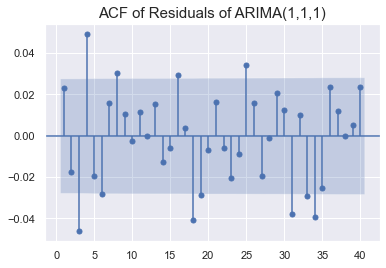

In [7]:
df['res_ar1_i1_ma1'] = results_ar1_i1_ma1.resid
sgt.plot_acf(df.res_ar1_i1_ma1[1:], zero=False, lags=40)
plt.title("ACF of Residuals of ARIMA(1,1,1)", size=15);

Third and fourth lags are significant

## Higher-Lag ARIMA Models

In [8]:
model_ar1_i1_ma2 = ARIMA(df.market_value, order = (1,1,2))
results_ar1_i1_ma2 = model_ar1_i1_ma2.fit()
model_ar1_i1_ma3 = ARIMA(df.market_value, order = (1,1,3))
results_ar1_i1_ma3 = model_ar1_i1_ma3.fit()
model_ar2_i1_ma1 = ARIMA(df.market_value, order = (2,1,1))
results_ar2_i1_ma1 = model_ar2_i1_ma1.fit()
model_ar3_i1_ma1 = ARIMA(df.market_value, order = (3,1,1))
results_ar3_i1_ma1 = model_ar3_i1_ma1.fit()
model_ar3_i1_ma2 = ARIMA(df.market_value, order = (3,1,2))
results_ar3_i1_ma2 = model_ar3_i1_ma2.fit(start_ar_lags = 5)

In [9]:
print("\n ARIMA(1,1,1) : \tLL = ", results_ar1_i1_ma1.llf, "\tAIC =",results_ar1_i1_ma1.aic)
print("\n ARIMA(1,1,2) : \tLL = ", results_ar1_i1_ma2.llf, "\tAIC =",results_ar1_i1_ma2.aic)
print("\n ARIMA(1,1,3) : \tLL = ", results_ar1_i1_ma3.llf, "\tAIC =",results_ar1_i1_ma3.aic)
print("\n ARIMA(2,1,1) : \tLL = ", results_ar2_i1_ma1.llf, "\tAIC =",results_ar2_i1_ma1.aic)
print("\n ARIMA(3,1,1) : \tLL = ", results_ar3_i1_ma1.llf, "\tAIC =",results_ar3_i1_ma1.aic)
print("\n ARIMA(3,1,2) : \tLL = ", results_ar3_i1_ma2.llf, "\tAIC =",results_ar3_i1_ma2.aic)



 ARIMA(1,1,1) : 	LL =  -27603.66641277381 	AIC = 55215.33282554762

 ARIMA(1,1,2) : 	LL =  -27600.08186311427 	AIC = 55210.16372622854

 ARIMA(1,1,3) : 	LL =  -27590.424032695926 	AIC = 55192.84806539185

 ARIMA(2,1,1) : 	LL =  -27599.807487850678 	AIC = 55209.614975701355

 ARIMA(3,1,1) : 	LL =  -27592.05537171336 	AIC = 55196.11074342672

 ARIMA(3,1,2) : 	LL =  -27590.660808971326 	AIC = 55195.32161794265


Here the ARIMA(1,1,3) has the highest LL and lowest AIC, hence is the best but (1,1,1) and (1,1,2) are nested with (1,1,3) so we should perform the LLR test to confirm that it really outperforms

In [10]:
LLR_Test(results_ar1_i1_ma2, results_ar1_i1_ma3) #This indicates that the complexity is necessary

0.0

In [11]:
LLR_Test(results_ar1_i1_ma1, results_ar1_i1_ma3, DF=2) #SO (1,1,3) appears to be the best choice out of the bunch

0.0

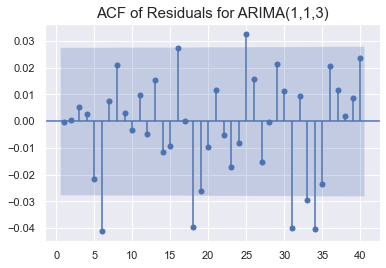

In [12]:
df['res_ar1_i1_ma3'] = results_ar1_i1_ma3.resid
sgt.plot_acf(df.res_ar1_i1_ma3[1:], zero=False, lags=40)
plt.title("ACF of Residuals for ARIMA(1,1,3)", size=15);

In [13]:
model_ar5_i1_ma1 = ARIMA(df.market_value, order = (5,1,1))
results_ar5_i1_ma1 = model_ar5_i1_ma1.fit(start_ar_lags=11)
model_ar6_i1_ma3 = ARIMA(df.market_value, order = (6,1,3))
results_ar6_i1_ma3 = model_ar6_i1_ma3.fit()

print("\n ARIMA(5,1,1) : \tLL = ", results_ar5_i1_ma1.llf, "\tAIC =",results_ar5_i1_ma1.aic)
print("\n ARIMA(6,1,3) : \tLL = ", results_ar6_i1_ma3.llf, "\tAIC =",results_ar6_i1_ma3.aic)  
print("\n ARIMA(1,1,3) : \tLL = ", results_ar1_i1_ma3.llf, "\tAIC =",results_ar1_i1_ma3.aic)


 ARIMA(5,1,1) : 	LL =  -27586.51188811405 	AIC = 55189.0237762281

 ARIMA(6,1,3) : 	LL =  -27581.455478171887 	AIC = 55184.910956343774

 ARIMA(1,1,3) : 	LL =  -27590.424032695926 	AIC = 55192.84806539185


(6,1,3) outperforms But since (1,1,3) and (5,1,1) are nested we can use LLR test to confirm that the additional complexity is worth it 

In [14]:
LLR_Test(results_ar1_i1_ma3, results_ar6_i1_ma3, DF=5) #Hence the higher complexity is rationalized as the LLR test gives a significant values 

0.003

In [15]:
LLR_Test(results_ar5_i1_ma1, results_ar6_i1_ma3, DF=3) 

0.018

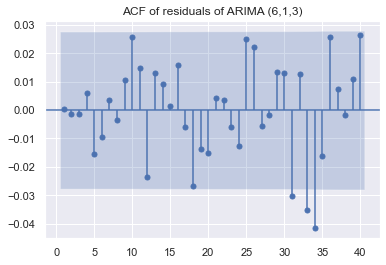

In [16]:
df['res_ar6_i1_ma3'] = results_ar6_i1_ma3.resid
sgt.plot_acf(df.res_ar6_i1_ma3[1:], zero=False, lags=40)
plt.title("ACF of residuals of ARIMA (6,1,3)");

## ARIMAX

Here we need to specify exogeneous argument called "exog"<br>
exog = array_type<br>
value associated with every time period<br>

In [17]:
model_ar1_i1_ma1_Xspx = ARIMA(df.market_value, exog=df.spx, order = (1,1,1)) #spx does not have a significant coefficient 
results_ar1_i1_ma1_Xspx = model_ar1_i1_ma1_Xspx.fit()                        # We can test the multiple variables as exog
results_ar1_i1_ma1_Xspx.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:         D.market_value   No. Observations:                 5020
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -27603.556
Method:                       css-mle   S.D. of innovations             59.132
Date:                Sun, 22 Aug 2021   AIC                          55217.112
Time:                        21:52:56   BIC                          55249.718
Sample:                    01-10-1994   HQIC                         55228.538
                         - 04-05-2013                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.5868      2.655     -0.221      0.825      -5.791       4.618
spx                      0.0011      0.002      0.450      0.652      -0.004       0.006
ar.L1.D.market_value     0.7456      0.070     10.578      0.000       0.607       0.884
ma.L1.D.market_value    -0.7917      0.065    -12.273      0.000      -0.918      -0.665
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.3412           +0.0000j            1.3412            0.0000
MA.1            1.2632           +0.0000j            1.2632            0.0000
-----------------------------------------------------------------------------
"""

## SARIMAX

In [18]:
model_sarimax = SARIMAX(df.market_value, exog=df.spx, order = (1,0,1), seasonal_order=(2,0,1,5)) 
results_sarimax = model_sarimax.fit()                        
results_sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                      market_value   No. Observations:                 5021
Model:             SARIMAX(1, 0, 1)x(2, 0, 1, 5)   Log Likelihood              -26712.624
Date:                           Sun, 22 Aug 2021   AIC                          53439.248
Time:                                   21:53:07   BIC                          53484.898
Sample:                               01-07-1994   HQIC                         53455.245
                                    - 04-05-2013                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
spx            2.7026      0.035     76.161      0.000       2.633       2.772
ar.L1          0.9998      0.000   2350.950      0.000       0.999       1.001
ma.L1         -0.3100      0.010    -32.552      0.000      -0.329      -0.291
ar.S.L5        0.9651      0.011     86.947      0.000       0.943       0.987
ar.S.L10       0.0345      0.010      3.351      0.001       0.014       0.055
ma.S.L5       -0.9989      0.006   -168.599      0.000      -1.010      -0.987
sigma2      2440.6058     28.398     85.944      0.000    2384.947    2496.264
===================================================================================
Ljung-Box (L1) (Q):                   1.62   Jarque-Bera (JB):              4206.93
Prob(Q):                              0.20   Prob(JB):                         0.00
Heteroskedasticity (H):               1.24   Skew:                            -0.52
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## ARCH (Autoregressive Conditional Heteroskedasticity Model)

Creating squred returns

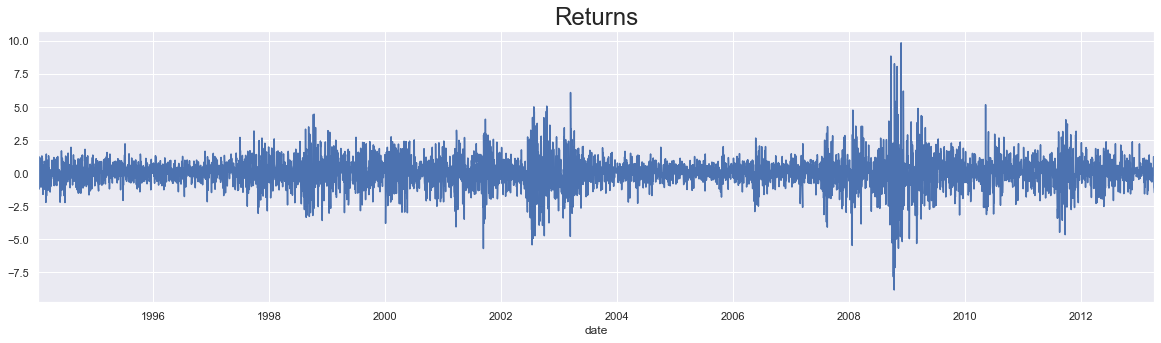

In [19]:
df['sq_returns'] = df.returns.mul(df.returns)
df.returns.plot(figsize=(20,5))
plt.title("Returns", size=24)
plt.show()

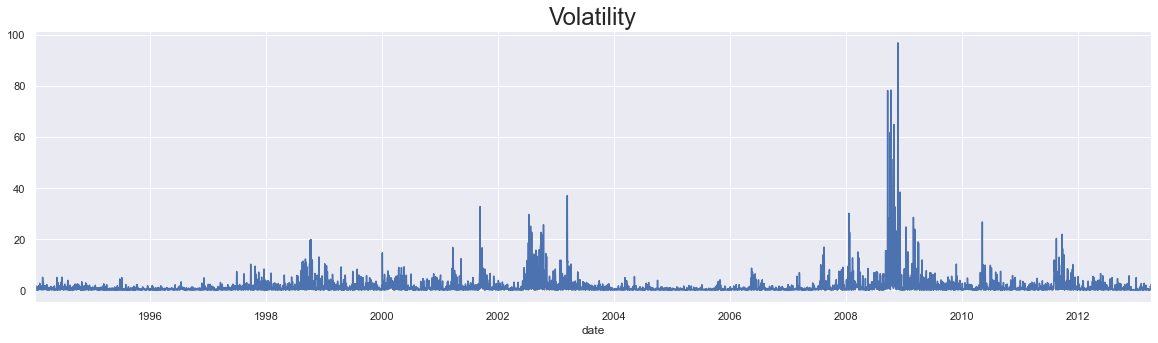

In [20]:
df.sq_returns.plot(figsize=(20,5))
plt.title("Volatility", size=24)
plt.show()

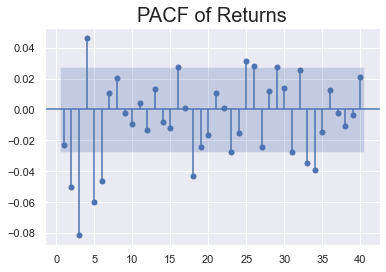

In [21]:
sgt.plot_pacf(df.returns[1:], zero=False, lags=40, alpha=0.05, method=('ols'))
plt.title("PACF of Returns", size=20)
plt.show()

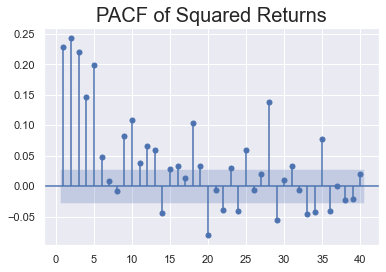

In [22]:
sgt.plot_pacf(df.sq_returns[1:], zero=False, lags=40, alpha=0.05, method=('ols'))
plt.title("PACF of Squared Returns", size=20)
plt.show()

In [26]:
model_arch1 = arch_model(df.returns[1:])
results_arch1 = model_arch1.fit(update_freq=5)
results_arch1.summary()

Iteration:      5,   Func. Count:     39,   Neg. LLF: 6972.734773031138
Iteration:     10,   Func. Count:     73,   Neg. LLF: 6970.088047158355
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6970.058366189876
            Iterations: 13
            Function evaluations: 91
            Gradient evaluations: 13


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -6970.06
Distribution:                  Normal   AIC:                           13948.1
Method:            Maximum Likelihood   BIC:                           13974.2
                                        No. Observations:                 5020
Date:                Sun, Aug 22 2021   Df Residuals:                     5019
Time:                        22:51:07   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0466  1.183e-02      3.939  8.187e-05 [2.342e-02,6.981e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0109  3.004e-03      3.640  2.724e-04 [5.048e-03,1.682e-02]
alpha[1]       0.0835  1.071e-02      7.794  6.476e-15   [6.249e-02,  0.104]
beta[1]        0.9089  1.148e-02     79.168      0.000     [  0.886,  0.931]
============================================================================

Covariance estimator: robust
"""

In [27]:
model_arch1 = arch_model(df.returns[1:], mean='AR', lags= [2,3,6], vol= "ARCH", p=1, dist='ged')
results_arch1 = model_arch1.fit(update_freq=5)
results_arch1.summary()

Iteration:      5,   Func. Count:     56,   Neg. LLF: 7392.97877844088
Iteration:     10,   Func. Count:    109,   Neg. LLF: 7320.749163320877
Iteration:     15,   Func. Count:    156,   Neg. LLF: 7317.119673961752
Iteration:     20,   Func. Count:    205,   Neg. LLF: 7317.118107649329
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 7317.118092667351
            Iterations: 22
            Function evaluations: 228
            Gradient evaluations: 22


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 AR - ARCH Model Results                                  
==========================================================================================
Dep. Variable:                            returns   R-squared:                       0.008
Mean Model:                                    AR   Adj. R-squared:                  0.007
Vol Model:                                   ARCH   Log-Likelihood:               -7317.12
Distribution:      Generalized Error Distribution   AIC:                           14648.2
Method:                        Maximum Likelihood   BIC:                           14693.9
                                                    No. Observations:                 5014
Date:                            Sun, Aug 22 2021   Df Residuals:                     5010
Time:                                    23:04:27   Df Model:                            4
                                  Mean Model                                  
==============================================================================
                 coef    std err          t      P>|t|        95.0% Conf. Int.
------------------------------------------------------------------------------
Const          0.0474  6.126e-03      7.739  9.992e-15   [3.540e-02,5.941e-02]
returns[2]    -0.0396  2.806e-02     -1.410      0.159  [-9.457e-02,1.543e-02]
returns[3]    -0.0348  5.931e-03     -5.863  4.544e-09 [-4.640e-02,-2.315e-02]
returns[6]    -0.0283  1.728e-03    -16.392  2.198e-60 [-3.170e-02,-2.493e-02]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0.9166  3.760e-02     24.378 2.956e-131 [  0.843,  0.990]
alpha[1]       0.3428  3.939e-02      8.703  3.229e-18 [  0.266,  0.420]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             1.0675  3.251e-02     32.842 1.488e-236 [  1.004,  1.131]
========================================================================

Covariance estimator: robust
"""

## Higher Lag ARCH Models

In [28]:
model_arch2 = arch_model(df.returns[1:], mean='Constant', lags= [2,3,6], vol= "ARCH", p=2, dist='ged')
results_arch2 = model_arch2.fit(update_freq=5)
results_arch2.summary()

Iteration:      5,   Func. Count:     43,   Neg. LLF: 7245.981256953115
Iteration:     10,   Func. Count:     83,   Neg. LLF: 7227.262335973003
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 7226.892580231268
            Iterations: 14
            Function evaluations: 111
            Gradient evaluations: 14


<class 'statsmodels.iolib.summary.Summary'>
"""
                            Constant Mean - ARCH Model Results                            
==========================================================================================
Dep. Variable:                            returns   R-squared:                       0.000
Mean Model:                         Constant Mean   Adj. R-squared:                  0.000
Vol Model:                                   ARCH   Log-Likelihood:               -7226.89
Distribution:      Generalized Error Distribution   AIC:                           14463.8
Method:                        Maximum Likelihood   BIC:                           14496.4
                                                    No. Observations:                 5020
Date:                            Sun, Aug 22 2021   Df Residuals:                     5019
Time:                                    23:08:13   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0370  1.822e-02      2.033  4.209e-02 [1.323e-03,7.274e-02]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0.6838  3.211e-02     21.298 1.195e-100 [  0.621,  0.747]
alpha[1]       0.2202  2.985e-02      7.377  1.618e-13 [  0.162,  0.279]
alpha[2]       0.2898  3.121e-02      9.287  1.585e-20 [  0.229,  0.351]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             1.1596  3.588e-02     32.318 3.887e-229 [  1.089,  1.230]
========================================================================

Covariance estimator: robust
"""

In [30]:
model_arch3 = arch_model(df.returns[1:], mean='Constant', vol= "ARCH", p=2)
results_arch3 = model_arch3.fit(update_freq=5)
results_arch3.summary()

Iteration:      5,   Func. Count:     41,   Neg. LLF: 7449.870533644225
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 7449.545164098214
            Iterations: 9
            Function evaluations: 67
            Gradient evaluations: 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -7449.55
Distribution:                  Normal   AIC:                           14907.1
Method:            Maximum Likelihood   BIC:                           14933.2
                                        No. Observations:                 5020
Date:                Sun, Aug 22 2021   Df Residuals:                     5019
Time:                        23:12:36   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0484  1.401e-02      3.455  5.495e-04 [2.095e-02,7.585e-02]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0.6978  3.564e-02     19.580  2.272e-85 [  0.628,  0.768]
alpha[1]       0.2202  3.474e-02      6.339  2.311e-10 [  0.152,  0.288]
alpha[2]       0.2783  3.645e-02      7.635  2.260e-14 [  0.207,  0.350]
========================================================================

Covariance estimator: robust
"""

In [34]:
model_arch13 = arch_model(df.returns[1:], mean='Constant', vol= "ARCH", p=13)
results_arch13 = model_arch13.fit(update_freq=5)
results_arch13.summary()

Iteration:      5,   Func. Count:     93,   Neg. LLF: 6996.500044128842
Iteration:     10,   Func. Count:    188,   Neg. LLF: 6985.661362868198
Iteration:     15,   Func. Count:    283,   Neg. LLF: 6984.395219801457
Iteration:     20,   Func. Count:    378,   Neg. LLF: 6984.217127218106
Iteration:     25,   Func. Count:    468,   Neg. LLF: 6984.175138096466
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6984.175062617
            Iterations: 27
            Function evaluations: 502
            Gradient evaluations: 27


<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -6984.18
Distribution:                  Normal   AIC:                           13998.4
Method:            Maximum Likelihood   BIC:                           14096.2
                                        No. Observations:                 5020
Date:                Sun, Aug 22 2021   Df Residuals:                     5019
Time:                        23:15:43   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0492  1.206e-02      4.077  4.566e-05 [2.553e-02,7.281e-02]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.1871  2.210e-02      8.466  2.538e-17      [  0.144,  0.230]
alpha[1]       0.0568  1.729e-02      3.282  1.029e-03  [2.287e-02,9.065e-02]
alpha[2]       0.1156  2.017e-02      5.733  9.840e-09    [7.610e-02,  0.155]
alpha[3]       0.1265  2.625e-02      4.820  1.433e-06    [7.509e-02,  0.178]
alpha[4]       0.0884  2.159e-02      4.093  4.265e-05    [4.605e-02,  0.131]
alpha[5]       0.0695  1.750e-02      3.970  7.189e-05    [3.518e-02,  0.104]
alpha[6]       0.0865  1.926e-02      4.491  7.092e-06    [4.874e-02,  0.124]
alpha[7]       0.0404  1.846e-02      2.188  2.870e-02  [4.203e-03,7.658e-02]
alpha[8]       0.0654  1.833e-02      3.565  3.633e-04    [2.943e-02,  0.101]
alpha[9]       0.0292  1.603e-02      1.820  6.877e-02 [-2.244e-03,6.058e-02]
alpha[10]      0.0335  1.605e-02      2.089  3.670e-02  [2.072e-03,6.498e-02]
alpha[11]      0.0775  1.760e-02      4.403  1.067e-05    [4.300e-02,  0.112]
alpha[12]      0.0473  1.873e-02      2.526  1.153e-02  [1.060e-02,8.402e-02]
alpha[13]      0.0372  1.431e-02      2.600  9.317e-03  [9.162e-03,6.526e-02]
=============================================================================

Covariance estimator: robust
"""

Here alpha9 is not significant anymore

## GARCH Model

In [37]:
model_garch1 = arch_model(df.returns[1:], mean='Constant', vol= "GARCH", p = 1, q = 1)
results_garch1 = model_garch1.fit(update_freq=5)
results_garch1.summary() #This model is the best for time being

Iteration:      5,   Func. Count:     39,   Neg. LLF: 6972.734773031138
Iteration:     10,   Func. Count:     73,   Neg. LLF: 6970.088047158355
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6970.058366189876
            Iterations: 13
            Function evaluations: 91
            Gradient evaluations: 13


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -6970.06
Distribution:                  Normal   AIC:                           13948.1
Method:            Maximum Likelihood   BIC:                           13974.2
                                        No. Observations:                 5020
Date:                Sun, Aug 22 2021   Df Residuals:                     5019
Time:                        23:33:52   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0466  1.183e-02      3.939  8.187e-05 [2.342e-02,6.981e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0109  3.004e-03      3.640  2.724e-04 [5.048e-03,1.682e-02]
alpha[1]       0.0835  1.071e-02      7.794  6.476e-15   [6.249e-02,  0.104]
beta[1]        0.9089  1.148e-02     79.168      0.000     [  0.886,  0.931]
============================================================================

Covariance estimator: robust
"""

## Higher-lag GARCH Models

In [38]:
model_garch_1_2 = arch_model(df.returns[1:], mean='Constant', vol= "GARCH", p = 1, q = 2)
results_garch_1_2 = model_garch_1_2.fit(update_freq=5)
results_garch_1_2.summary()

Iteration:      5,   Func. Count:     44,   Neg. LLF: 6978.5939702909645
Iteration:     10,   Func. Count:     80,   Neg. LLF: 6970.063568602713
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6970.058366386507
            Iterations: 12
            Function evaluations: 95
            Gradient evaluations: 12


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -6970.06
Distribution:                  Normal   AIC:                           13950.1
Method:            Maximum Likelihood   BIC:                           13982.7
                                        No. Observations:                 5020
Date:                Sun, Aug 22 2021   Df Residuals:                     5019
Time:                        23:38:46   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0466  1.184e-02      3.938  8.219e-05 [2.341e-02,6.982e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0109  2.908e-03      3.761  1.696e-04 [5.236e-03,1.663e-02]
alpha[1]       0.0835  1.189e-02      7.019  2.230e-12   [6.017e-02,  0.107]
beta[1]        0.9089      0.188      4.845  1.267e-06     [  0.541,  1.277]
beta[2]    1.4984e-08      0.180  8.334e-08      1.000     [ -0.352,  0.352]
============================================================================

Covariance estimator: robust
"""

Garch (1,1) is the best model for measuring volatility of returns, and there's no need to rely on overly complicated model